## Grover's Algorithm
Author: Nico Kuijpers
Date: April 22, 2024

This notebook is based on the following notebook from Qiskit, but uses the Fontys Quantum Simulator instead of Qiskit.

https://learning.quantum.ibm.com/tutorial/grovers-algorithm

To run this notebook, you will need the python code files *quantumutil.py* and *quantumsim.py*. It is assumed that these two files are located in subdirectory *quantumsim_package*. This directory should also contain an empty file named *`__init__.py`*. In the code below, subdirectory *quantumsim_package* is added to the python search path.

In [1]:
import sys
sys.path.append('quantumsim_package')

Import the modules *quantumutil* and *quantumsim* containing utilities and the quantum computer simulator.

In [2]:
from quantumsim_package.quantumutil import *
from quantumsim_package.quantumsim import *

Import other packages.

In [3]:
import numpy as np
from numpy import pi

### Step 1: Map classical inputs to a quantum problem

In [4]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        Circuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    # Create the circuit
    circuit = Circuit(num_qubits)

    # Mark each target state in the input list
    for target in marked_states:
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if target.startswith("0",ind)]

        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        for i in zero_inds:
            circuit.apply_pauli_x(i)
        circuit.apply_multi_controlled_pauli_z()
        for i in zero_inds:
            circuit.apply_pauli_x(i)

    return circuit

In [5]:
def grover_operator(oracle:Circuit):
    grover = Circuit(oracle.N)
    grover.append_circuit(oracle)
    for q in range (grover.N):
        grover.apply_hadamard(q)
    for q in range (grover.N):
        grover.apply_pauli_x(q)
    grover.apply_hadamard(grover.N - 1)
    grover.apply_multi_controlled_pauli_x() 
    grover.apply_hadamard(grover.N - 1)
    for q in range (grover.N):
        grover.apply_pauli_x(q)
    for q in range (grover.N):
        grover.apply_hadamard(q)
    return grover

In [6]:
def optimal_num_iterations(marked_states):
    return max(1,math.floor(math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**len(marked_states[0]))))))

In [7]:
def create_grover_circuit(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    nr_iterations = optimal_num_iterations(marked_states)
    oracle = grover_oracle(marked_states)
    circuit = Circuit(oracle.N)
    circuit_grover_operator = grover_operator(oracle)
    for q in range(oracle.N):
        circuit.apply_hadamard(q)
    for i in range(nr_iterations):
        circuit.append_circuit(circuit_grover_operator)
    return circuit

In [8]:
#marked_states = ["00"] # 1 iteration, output correct
#marked_states = ["01"] # 1 iteration, output correct
#marked_states = ["01","10"] # 1 iteration, gives all possible states as output
#marked_states = ["01","10","11"] # 1 iteration, gives output |00>
#marked_states = ["000","111"] # 1 iteration
#marked_states = ["100","101"] # 1 iteration
#marked_states = ["100"] # 2 iterations
#marked_states = ["1010"] # 3 iterations
#marked_states = ["0101","1010"] # 2 iterations
#marked_states = ["0001","0010","0100","1000"] # 1 iteration
#marked_states = ["0000","0001","0011","0111","1111"] # 1 iteration
#marked_states = ["01010","01011","01110","10101"] # 2 iterarations
marked_states = ["01011","10101"] # 3 iterarations
#marked_states = ["01011"] # 4 iterarations

In [9]:
nr_iterations = optimal_num_iterations(marked_states)
print(f"Nr iterations is {nr_iterations} for marked states {marked_states}")

Nr iterations is 3 for marked states ['01011', '10101']


In [10]:
circuit = create_grover_circuit(marked_states)

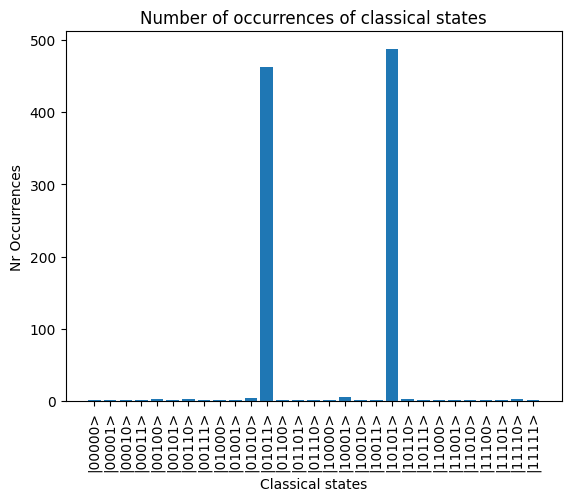

In [11]:
result = run_circuit(circuit,nr_runs=1000)
histogram_of_classical_states(result)

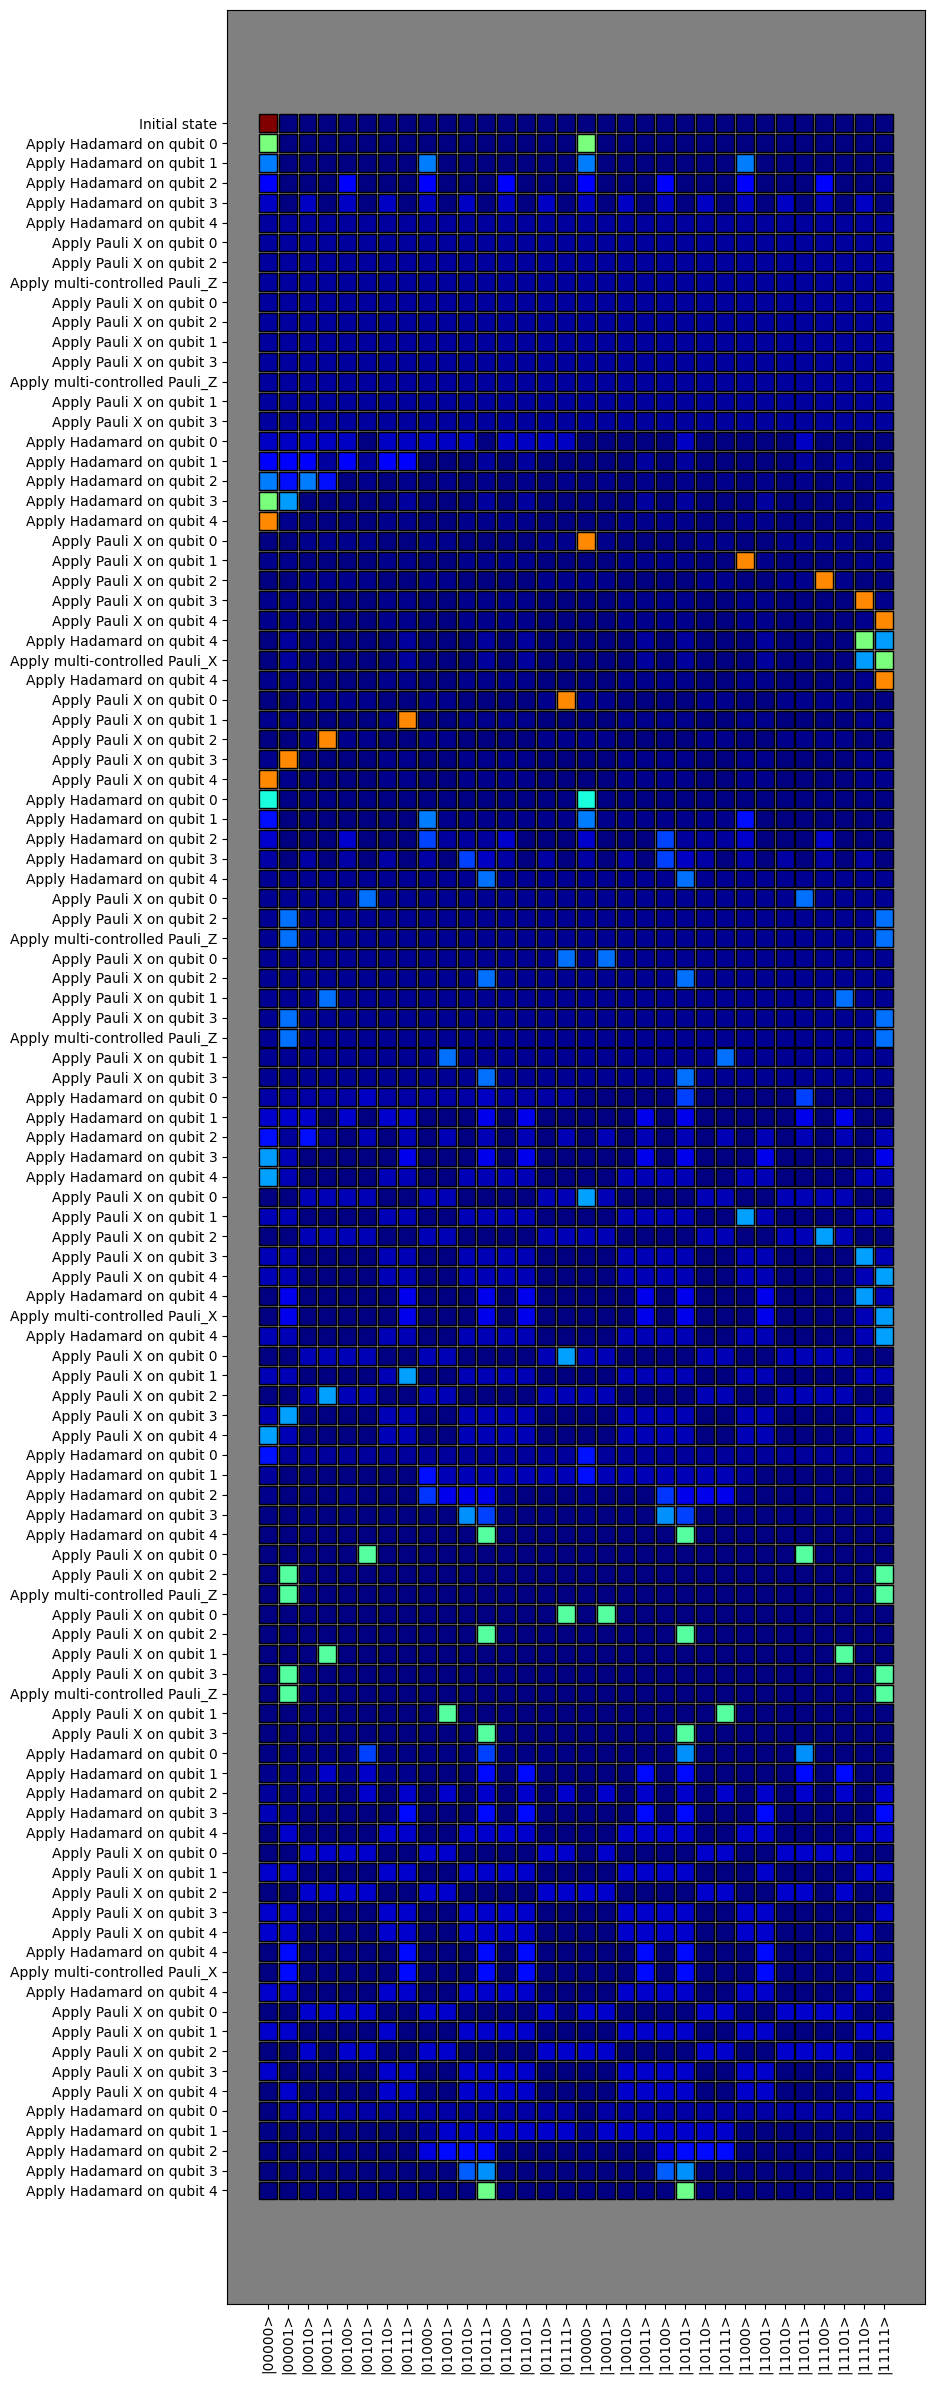

In [12]:
show_all_pobrabilities(circuit)

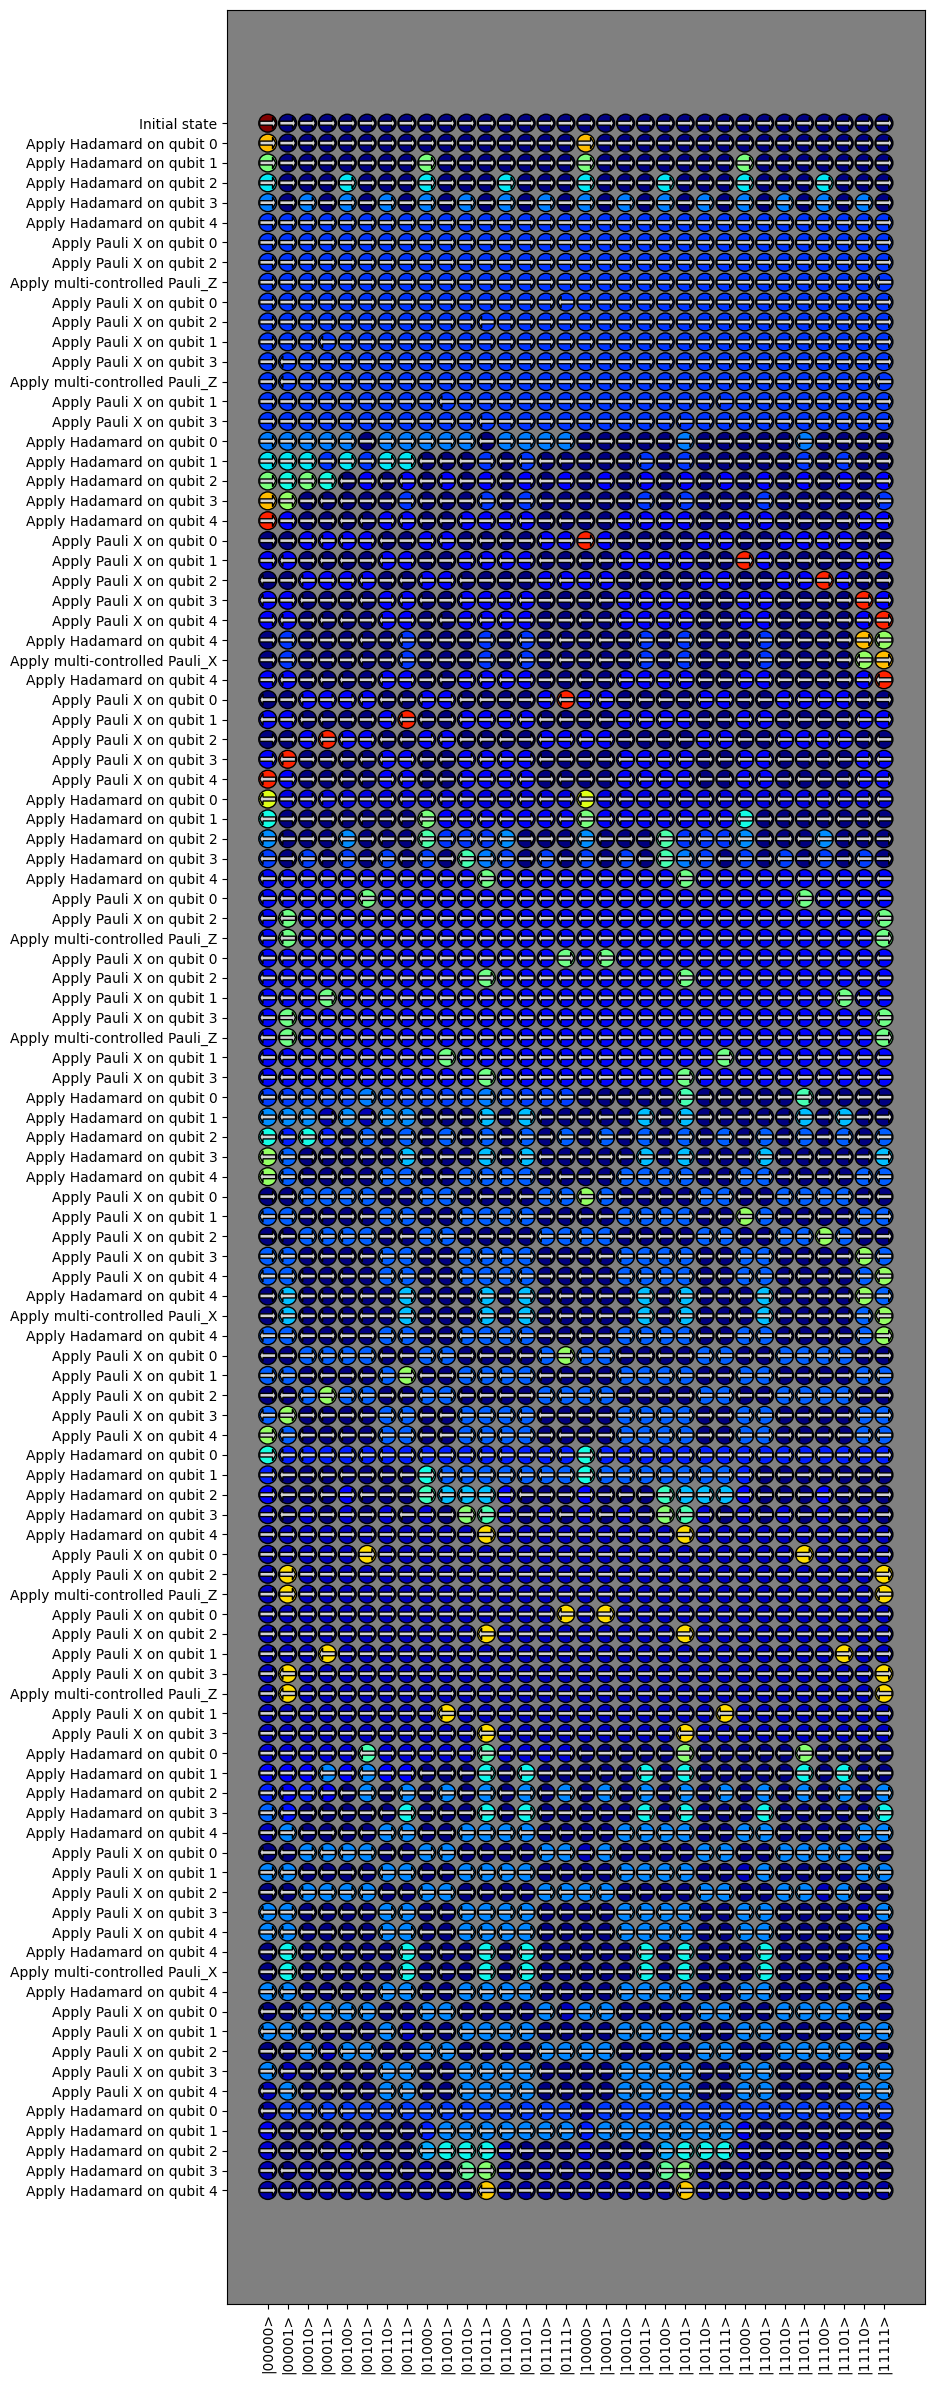

In [13]:
show_all_intermediate_states(circuit)